In [1]:
import sys
sys.path.append(r'/home/mhasan3/Desktop/WorkFolder/')

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [3]:
# import the necessary keras packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from imutils import paths

In [4]:
args = {
    "db" : r"/home/mhasan3/Desktop/WorkFolder/Datasets/flowers17/images/",
    "model" : r"./"
}

In [6]:
# construct image generator
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [7]:
# grab the list of images
print(f'[INFO] loading images.....')
image_paths = list(paths.list_images(args["db"]))
class_names = [pt.split(os.path.sep)[-2] for pt in image_paths]
unique_class_names = [pt for pt in np.unique(class_names)]
print(unique_class_names)

[INFO] loading images.....
['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


In [8]:
# init the image preprocessors
aap = AspectAwarePreprocessor(width=224, height=224)
iap = ImageToArrayPreprocessor()

# load the dataset then scale raw pixel
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
data, labels = sdl.load(image_paths, verbose=500)
data = data.astype('float') / 255.0

[INFO] processed 500/1360
[INFO] processed 1000/1360


In [9]:
# now partition the data into traintest splits
trainx, testx, trainy, testy = train_test_split(data,
                                                labels,
                                                test_size=0.25,
                                                random_state=42)
# binarise the labels
lb = LabelBinarizer()
trainy = lb.fit_transform(trainy)
testy = lb.transform(testy)

In [10]:
# load and construct the models
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_tensor=Input(shape=(224, 224, 3))) # type: Model

# init the new head of the network
head_model = FCHeadNet.builld(baseModel=base_model,
                              classes=len(unique_class_names),
                              fc_nodes=[256])
model = Model(inputs=base_model.input, outputs=head_model)

# freeze the base model
for layer in base_model.layers:
    layer = layer # type: Layer
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 5s 0us/step
BaseModel Out Shape:  (?, 7, 7, 512)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
# now compile the model and fit it
print(f'[INFO] compiling the model.....')
opt = RMSprop(lr=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

print(f'[INFO] training the head only.....')
H = model.fit_generator(aug.flow(trainx, trainy, batch_size=32),
                    validation_data=(testx, testy),
                    epochs=25,
                    steps_per_epoch=len(trainx) // 32,
                    verbose=1)

[INFO] compiling the model.....
[INFO] training the head only.....
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
32/32 [==============================] - 14s 435ms/step - loss: 7.3980 - acc: 0.1284 - val_loss: 2.1815 - val_acc: 0.4412
Epoch 2/25
32/32 [==============================] - 7s 233ms/step - loss: 2.3860 - acc: 0.2706 - val_loss: 1.8153 - val_acc: 0.4412
Epoch 3/25
32/32 [==============================] - 8s 257ms/step - loss: 2.0474 - acc: 0.3765 - val_loss: 1.3850 - val_acc: 0.5794
Epoch 4/25
32/32 [==============================] - 8s 260ms/step - loss: 1.7434 - acc: 0.4480 - val_loss: 1.1741 - val_acc: 0.6324
Epoch 5/25
32/32 [==============================] - 9s 272ms/step - loss: 1.5159 - acc: 0.5078 - val_loss: 0.9747 - val_acc: 0.7147
Epoch 6/25
32/32 [==============================] - 8s 238ms/step - loss: 1.3843 - acc: 0.5676 - val_loss: 1.0425 - val_acc: 0.6794
Epoch 7/25
32/32 [==============================] - 8s 242ms/step - loss: 1.3339 - acc: 0.59

In [12]:
# evaluate network after head warm up
# evaluate the network
print ( "[INFO] evaluating network..." )
predictions = model.predict(testx, batch_size=32 )
print (classification_report(testy.argmax(axis=1 ),
predictions.argmax(axis=1 ), target_names=unique_class_names))

[INFO] evaluating network...
              precision    recall  f1-score   support

    bluebell       0.81      0.85      0.83        20
   buttercup       0.91      0.91      0.91        22
   coltsfoot       0.74      0.93      0.82        15
     cowslip       0.71      1.00      0.83        20
      crocus       0.72      0.91      0.81        23
    daffodil       0.71      0.67      0.69        18
       daisy       1.00      0.95      0.97        19
   dandelion       1.00      0.75      0.86        20
  fritillary       0.94      0.85      0.89        20
        iris       0.93      0.88      0.90        16
  lilyvalley       0.91      0.91      0.91        23
       pansy       0.89      1.00      0.94        16
    snowdrop       0.94      0.74      0.83        23
   sunflower       1.00      1.00      1.00        19
   tigerlily       0.93      0.96      0.95        27
       tulip       0.83      0.48      0.61        21
  windflower       0.75      0.83      0.79        1

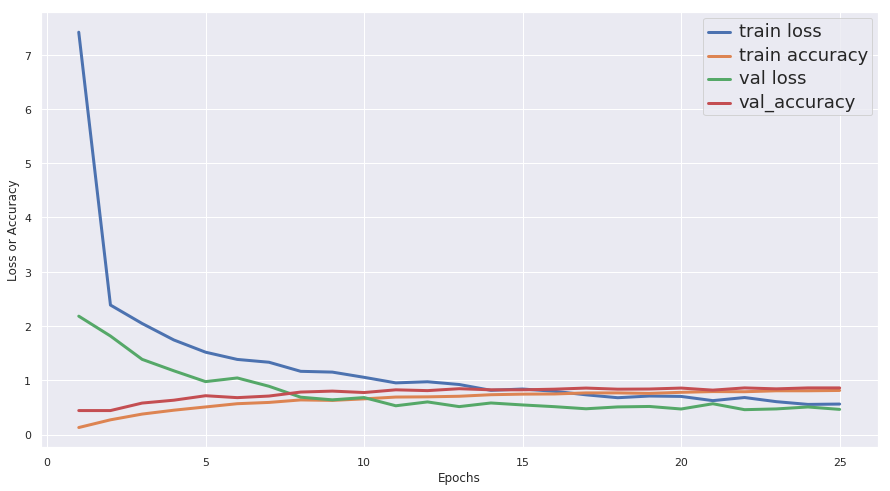

In [13]:
# plot the performance
epochs = range(1,26)
loss = H.history['loss']
accuracy = H.history['acc']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_acc']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [17]:
# now unfreeze final set of CONV layers
for layer in base_model.layers[15:]:
    layer = layer # type: Layer
    layer.trainable = True

In [18]:
print(f'[INFO] re-compiling model.....')
opt = SGD(lr=0.001)
model.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=["accuracy"])

print(f'[INFO] fine tuning the model.....')
H = model.fit_generator(aug.flow(trainx, trainy, batch_size=32),
                        validation_data=(testx, testy),
                        verbose=1, epochs=100)

[INFO] re-compiling model.....
[INFO] fine tuning the model.....
Epoch 1/100
32/32 [==============================] - 9s 277ms/step - loss: 0.2897 - acc: 0.9020 - val_loss: 0.3501 - val_acc: 0.8882
Epoch 2/100
32/32 [==============================] - 8s 242ms/step - loss: 0.3591 - acc: 0.8775 - val_loss: 0.3580 - val_acc: 0.8971
Epoch 3/100
32/32 [==============================] - 9s 274ms/step - loss: 0.3444 - acc: 0.8863 - val_loss: 0.3496 - val_acc: 0.8971
Epoch 4/100
32/32 [==============================] - 9s 277ms/step - loss: 0.2762 - acc: 0.9049 - val_loss: 0.3626 - val_acc: 0.8971
Epoch 5/100
32/32 [==============================] - 8s 248ms/step - loss: 0.2749 - acc: 0.9088 - val_loss: 0.3723 - val_acc: 0.8971
Epoch 6/100
32/32 [==============================] - 8s 248ms/step - loss: 0.2829 - acc: 0.9059 - val_loss: 0.3455 - val_acc: 0.9029
Epoch 7/100
32/32 [==============================] - 8s 262ms/step - loss: 0.2651 - acc: 0.9186 - val_loss: 0.3437 - val_acc: 0.9029
Epoc

Epoch 38/100
32/32 [==============================] - 8s 242ms/step - loss: 0.1588 - acc: 0.9431 - val_loss: 0.2811 - val_acc: 0.9147
Epoch 39/100
32/32 [==============================] - 8s 237ms/step - loss: 0.1766 - acc: 0.9490 - val_loss: 0.3113 - val_acc: 0.9118
Epoch 40/100
32/32 [==============================] - 8s 241ms/step - loss: 0.1755 - acc: 0.9461 - val_loss: 0.2732 - val_acc: 0.9235
Epoch 41/100
32/32 [==============================] - 8s 246ms/step - loss: 0.1483 - acc: 0.9520 - val_loss: 0.3233 - val_acc: 0.9088
Epoch 42/100
32/32 [==============================] - 8s 251ms/step - loss: 0.1617 - acc: 0.9461 - val_loss: 0.3168 - val_acc: 0.9059
Epoch 43/100
32/32 [==============================] - 8s 246ms/step - loss: 0.1415 - acc: 0.9539 - val_loss: 0.2992 - val_acc: 0.9147
Epoch 44/100
32/32 [==============================] - 8s 238ms/step - loss: 0.1562 - acc: 0.9471 - val_loss: 0.2951 - val_acc: 0.9059
Epoch 45/100
32/32 [==============================] - 8s 243ms

32/32 [==============================] - 8s 254ms/step - loss: 0.0952 - acc: 0.9676 - val_loss: 0.3212 - val_acc: 0.9118
Epoch 76/100
32/32 [==============================] - 8s 235ms/step - loss: 0.1126 - acc: 0.9637 - val_loss: 0.2953 - val_acc: 0.9324
Epoch 77/100
32/32 [==============================] - 8s 240ms/step - loss: 0.1011 - acc: 0.9657 - val_loss: 0.3131 - val_acc: 0.9206
Epoch 78/100
32/32 [==============================] - 8s 244ms/step - loss: 0.1042 - acc: 0.9647 - val_loss: 0.2989 - val_acc: 0.9324
Epoch 79/100
32/32 [==============================] - 8s 242ms/step - loss: 0.1289 - acc: 0.9529 - val_loss: 0.3414 - val_acc: 0.9206
Epoch 80/100
32/32 [==============================] - 8s 242ms/step - loss: 0.0943 - acc: 0.9676 - val_loss: 0.3313 - val_acc: 0.9206
Epoch 81/100
32/32 [==============================] - 9s 267ms/step - loss: 0.1173 - acc: 0.9608 - val_loss: 0.2878 - val_acc: 0.9147
Epoch 82/100
32/32 [==============================] - 8s 264ms/step - loss:

In [19]:
# evaluate the network
print ( "[INFO] evaluating network..." )
predictions = model.predict(testx, batch_size=32 )
print (classification_report(testy.argmax(axis=1 ),
predictions.argmax(axis=1 ), target_names=unique_class_names))

[INFO] evaluating network...
              precision    recall  f1-score   support

    bluebell       0.86      0.95      0.90        20
   buttercup       0.95      0.91      0.93        22
   coltsfoot       0.87      0.87      0.87        15
     cowslip       0.76      0.95      0.84        20
      crocus       0.95      0.87      0.91        23
    daffodil       0.94      0.83      0.88        18
       daisy       1.00      0.95      0.97        19
   dandelion       0.95      0.90      0.92        20
  fritillary       1.00      0.85      0.92        20
        iris       1.00      0.88      0.93        16
  lilyvalley       0.96      1.00      0.98        23
       pansy       0.89      1.00      0.94        16
    snowdrop       0.85      1.00      0.92        23
   sunflower       1.00      1.00      1.00        19
   tigerlily       0.96      0.96      0.96        27
       tulip       0.89      0.81      0.85        21
  windflower       0.89      0.89      0.89        1

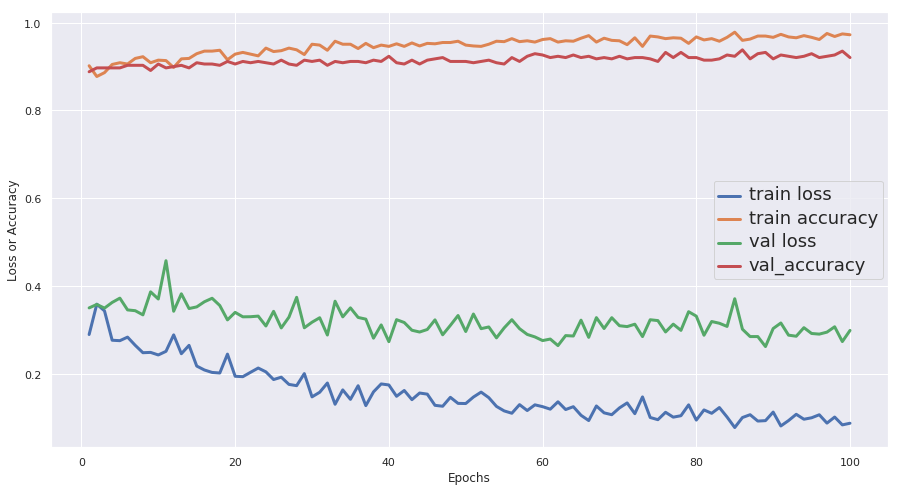

In [20]:
# plot the performance
epochs = range(1,101)
loss = H.history['loss']
accuracy = H.history['acc']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_acc']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [23]:
# save the model
model.save("model_finetune_flower17.hdf5")